In [38]:
import gdrive_refs as names
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

After importing the Python libraries, we load the datasets into a dictionary name `datasets`

In [39]:
root = "./data/"
datasets = dict()
for name in names.gdrive_dic:
    address = root+name[1]
    datasets[name[1]] = pd.read_csv(address, on_bad_lines='skip')

# Can we infer annual death tolls attributable to air pollution with AQI?

One of our goals in this project is to relate deaths tolls of air pollution to the data we have in the dataset of the class. A first idea that came to our mind was to use $AQI$ for Air Quality Index. It is metrics used to depict air quality based on the concentration of pollutants in the air.

### _Why would we use $AQI$?_

$AQI$ is a convenient index that not only indicates well whether the air is dangerous for health, but is also much more accessible to the public. In fact states usually give $AQI$s and not the concentrations of pollutants measured in the outdoor air. ([Here](https://www.airnow.gov/aqi/aqi-calculator/) is an example) 

However, we saw by doing digging on our end that it is easier to relate deaths to the $PM2.5$, a measurement of density of polluting particules over a 24h time window. One way to do it is to use data from the WHO and relate deaths to $PM2.5$. This way we would like to create a data pipeline that would help anyone assess attributable deaths due to pollution with accessible data (here $AQI$).

### _Initial methodology_

We want to first create data pipeline: $ AQI \rightarrow PM2.5 \rightarrow Attributable\;Deaths$. In this way, we want to infer deaths attributable to air pollution using $AQIs$. However the data we find available online as a validation set begins at the year 2001 and stops at the year 2016. This way we will be doing inferencing on $AQI$s data from the years 2001 to 2016 from the Environmental Protection Agency ([EPA](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Annual)). We will show that this method is unfortunately inaccurate as there is not a linear relationship between $AQI$ and $PM2.5$. Instead we will fit a *Sigmoid function* based on the computation of $AQIs$ and

# _EDA_

**Creating the jointed dataset of $AQIs$ from 2001 to 2016 with `pandas`**

In [51]:
years = [str(i) for i in range(2001,2017)]
annual_aqi_us_county = datasets["annual_aqi_by_county_2000.csv"].loc[:,['Year', 'State', 'County','Median AQI']]
increment = 1
for year in years:
    df = datasets["annual_aqi_by_county_"+year+".csv"].loc[:,['Year', 'State', 'County','Median AQI']]
    annual_aqi_us_county = pd.concat([annual_aqi_us_county, df], axis=0)
    increment += 1

Printing for checking

In [52]:
annual_aqi_us_county

,Year,State,County,Median AQI
0,2000,Alabama,Baldwin,54
1,2000,Alabama,Clay,46
2,2000,Alabama,Colbert,16
3,2000,Alabama,DeKalb,51
4,2000,Alabama,Elmore,50
...,...,...,...,...
1049,2016,Wyoming,Sublette,44
1050,2016,Wyoming,Sweetwater,44
1051,2016,Wyoming,Teton,41
1052,2016,Wyoming,Uinta,42


**Creating the jointed dataset of $PM2.5s$ from 2001 to 2016 with `pandas`**

In [53]:
pm25_county = datasets["Daily_PM25_Concentrations_All_County_2001-2016.csv"]
pm25_county

,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,county,state
0,2001,01JAN2001,1,1,10.664367,10.264546,10.137631,10.188703,Baldwin,Baldwin
1,2001,01JAN2001,1,3,9.803209,8.739505,8.743748,8.811486,Baldwin,Baldwin
2,2001,01JAN2001,1,5,12.087599,11.809159,11.812775,11.802062,Baldwin,Baldwin
3,2001,01JAN2001,1,7,8.579425,8.435394,8.458118,8.448871,Baldwin,Baldwin
4,2001,01JAN2001,1,9,14.399446,13.577741,13.300528,13.231461,Baldwin,Baldwin
...,...,...,...,...,...,...,...,...,...,...
18168991,2016,31DEC2016,56,37,9.436500,7.100500,7.251233,7.260799,Pope,Pope
18168992,2016,31DEC2016,56,39,4.195300,3.823850,3.674600,3.746709,Pope,Pope
18168993,2016,31DEC2016,56,41,17.849100,16.394300,15.252833,15.363383,Pope,Pope
18168994,2016,31DEC2016,56,43,2.907300,2.801800,2.667467,2.635025,Pope,Pope


Quick EDA shows that datasets diverge for multiple reasons:

1. `Daily_PM25_Concentrations_All_County_2001-2016.csv` gives daily $PM2.5$ concentration on all counties of the state. Further processing will therefore required: estimating the average $PM2.5$ along the years and counties.
2. `annual_aqi_us_county` dataframe does not embedd states nor county fips, which would be interesting to do in case $AQI$ is uncorrelated to $PM2.5$. 

This way we will implement the former suggestions using `zip` and dictionnaries.

In [54]:
counties = tuple(annual_aqi_us_county['County'].unique())
states = tuple(annual_aqi_us_county['State'].unique())

# For PM2.5
county_names = dict(zip(tuple([i for i in range(1,len(counties)+1)]),counties)) 
states_names = dict(zip(tuple([i for i in range(1,len(states)+1)]),states)) 
pm25_county['county'] = pm25_county['statefips'].replace(county_names)
pm25_county['state'] = pm25_county['countyfips'].replace(county_names)

# For AQIS
county_fips = dict(zip(counties,tuple([i for i in range(1,len(counties)+1)]))) 
states_fips = dict(zip(states,tuple([i for i in range(1,len(states)+1)])))
annual_aqi_us_county['CountyFips'] = annual_aqi_us_county['County'].replace(county_fips).astype('int')
annual_aqi_us_county['StateFips'] = annual_aqi_us_county['State'].replace(county_fips).astype('int')

ValueError: invalid literal for int() with base 10: 'Alabama'

In [ ]:
pm25_county = pm25_county.groupby(['year','state','county']).mean().reset_index()
pm25_county

,year,state,county,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
0,2001,Anchorage,Anchorage,24.0,44.958333,15.405197,14.521819,14.495412,14.501013
1,2001,Apache,Apache,30.0,56.000000,7.692111,7.498585,7.494960,7.494061
2,2001,Ashley,Ashley,44.0,5.000000,12.387606,11.683080,11.698517,11.703024
3,2001,Baldwin,Baldwin,1.0,67.000000,13.612037,12.991030,12.977554,12.981486
4,2001,Clark,Clark,45.0,46.000000,13.767778,13.097615,13.086085,13.097937
...,...,...,...,...,...,...,...,...,...
779,2016,Talladega,Talladega,21.0,120.000000,8.819415,8.545966,8.544520,8.547151
780,2016,Tuscaloosa,Tuscaloosa,22.0,64.000000,8.932974,8.488591,8.474220,8.480297
781,2016,Walker,Walker,23.0,16.000000,6.552335,5.868054,5.852267,5.880778
782,2016,Yavapai,Yavapai,41.0,36.000000,6.491167,5.880199,5.809797,5.851181


In [ ]:
annual_aqi_us = annual_aqi_us_county.groupby(['Year','State','County']).mean().reset_index()
annual_aqi_us

,Year,State,County,Median AQI,CountyFips,StateFips
0,2000,Alabama,Baldwin,54.0,1.0,1.0
1,2000,Alabama,Clay,46.0,1.0,1.0
2,2000,Alabama,Colbert,16.0,1.0,1.0
3,2000,Alabama,DeKalb,51.0,1.0,1.0
4,2000,Alabama,Elmore,50.0,1.0,1.0
...,...,...,...,...,...,...
18810,2016,Wyoming,Sublette,44.0,21.0,21.0
18811,2016,Wyoming,Sweetwater,44.0,21.0,21.0
18812,2016,Wyoming,Teton,41.0,21.0,21.0
18813,2016,Wyoming,Uinta,42.0,21.0,21.0


,year,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,Year,Median AQI,CountyFips,StateFips,log Median AQI,log PM25_med_pred
year,1.000000,0.005236,-0.040522,-0.554869,-0.553835,-0.553068,-0.553929,1.000000,-0.099993,0.013036,0.013036,-0.055137,-0.541318
statefips,0.005236,1.000000,0.240574,-0.148790,-0.114191,-0.113860,-0.114210,0.005236,0.049135,-0.241475,-0.241475,0.062962,-0.101071
countyfips,-0.040522,0.240574,1.000000,-0.043102,0.010700,0.012661,0.011497,-0.040522,-0.097631,-0.342372,-0.342372,-0.082179,0.032903
PM25_max_pred,-0.554869,-0.148790,-0.043102,1.000000,0.995027,0.994635,0.994813,-0.554869,0.034889,0.160628,0.160628,0.005799,0.984041
PM25_med_pred,-0.553835,-0.114191,0.010700,0.995027,1.000000,0.999967,0.999976,-0.553835,0.028153,0.140217,0.140217,0.001462,0.989801
PM25_mean_pred,-0.553068,-0.113860,0.012661,0.994635,0.999967,1.000000,0.999989,-0.553068,0.027654,0.141087,0.141087,0.001126,0.990060
PM25_pop_pred,-0.553929,-0.114210,0.011497,0.994813,0.999976,0.999989,1.000000,-0.553929,0.028404,0.141467,0.141467,0.001691,0.989968
Year,1.000000,0.005236,-0.040522,-0.554869,-0.553835,-0.553068,-0.553929,1.000000,-0.099993,0.013036,0.013036,-0.055137,-0.541318
Median AQI,-0.099993,0.049135,-0.097631,0.034889,0.028153,0.027654,0.028404,-0.099993,1.000000,-0.030558,-0.030558,0.918112,0.015624
CountyFips,0.013036,-0.241475,-0.342372,0.160628,0.140217,0.141087,0.141467,0.013036,-0.030558,1.000000,1.000000,-0.020944,0.149385


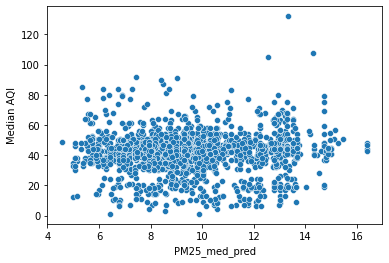

In [ ]:
joined_aqi_pm25_us = pm25_county.merge(annual_aqi_us, left_on = ['year','county'], right_on = ['Year','County'])

joined_aqi_pm25_us['log Median AQI'] = joined_aqi_pm25_us['Median AQI'].apply(np.log)
joined_aqi_pm25_us['log PM25_med_pred'] = joined_aqi_pm25_us['PM25_med_pred'].apply(np.log)

sns.scatterplot(data = joined_aqi_pm25_us, x = 'PM25_med_pred', y = 'Median AQI')
joined_aqi_pm25_us.corr()

Making a linear Machine Learning model out of this plot looks impossible. Looking at what is available online, we see that taking the median of $AQI$s. In fact the formula to calculate $AQI$ with $PM2.5$ is:

$$AQI = \frac{I_{Hi}-I_{Lo}}{BP_{Hi}-BP_{Lo}}(PM2.5-BP_{Lo})+I_{Lo}$$

Where:
| Variable | Explanation |
| --- | --- |
| $BP$ | the Breaking Point of PM2.5 in its corresponding range |
| $I$ | the Breaking Point of AQI in its corresponding range |

This means that with reasonable variations of PM2.5 is a union of linear segments. **Note that the measurements are taken on a 24h time window.**

In [47]:
from IPython.core.display import Image, display
Image(url='https://www.airveda.com/resources/images/aqi_calculation_update/chart.png')

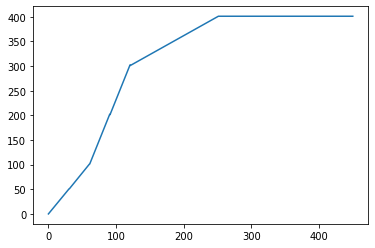

In [48]:
def aqi(x):
    if 0<=int(x)<=30:
        return(50/30*x)
    if 31<=int(x)<=60:
        return(49/29*(x-31)+51)
    if 61<=int(x)<=90:
        return((200-101)/(90-61)*(x-61)+101)
    if 91<=int(x)<=120:
        return(99/(120-91)*(x-91)+201)
    if 121<=int(x)<=250:
        return((400-301)/(250-121)*(x-121)+301)
    if 251<=int(x):
        return(401)
    else:
        return(0)

x_pm25 = np.linspace(0,450,900)
y_aqi = [aqi(e) for e in x_pm25]
plt.plot(x_pm25,y_aqi)

This function awfully looks like a **Sigmoid Function** curve of equation:

$$AQI(PM2.5)=\frac{400}{1+e^{-0.04\times(PM2.5-90)}}$$

... which can plot for reference

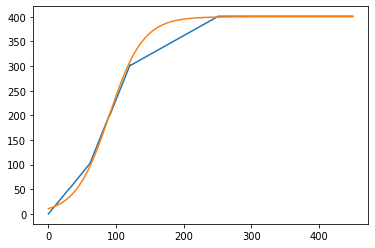

In [49]:
x_pm25 = np.linspace(0,450,900)
y_aqi = [aqi(e) for e in x_pm25]
y_pred_aqi = 400/(1+np.exp(0.4e-1*(-x_pm25+90)))
plt.plot(x_pm25,y_aqi)
plt.plot(x_pm25,y_pred_aqi)

# Conclusion

The decorrelation of annual median AQIs and annual mean PM2.5 make now much more sense since we are correlating an entry with the average of sigmoid functions. Not only there is no linear correlation between the two variables but there is also no simple transformation we can apply to the entries to correlate the two. As a result **it is not possible to relate annual deaths attributed to air pollution with median annual $AQI$**. We do not have a choice but to calculate 